In [1]:
# https://drive.google.com/drive/folders/1hNFbb-Ksc9Qdyx0_CB7tTJFy7-UNwYwy?usp=sharing 

# Bildgröße 300x200 RGB

from google.colab import drive
import torchvision 
from torchvision import transforms

from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from torchsummary import summary

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, random_split
from torchvision import datasets, transforms


In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Config Feld
path = f"/content/drive/MyDrive/Colab Notebooks/data/rps-cv-images" # GEÄNDERT
ModelPath = f'/content/drive/MyDrive/Colab Notebooks/models/pythorch.model'
device = "cuda" if torch.cuda.is_available() else "cpu"
TrainingMode = True

valid_size = 0.2
test_size = 0.4

epochs = 50

image_width = 300   
image_height = 200


In [4]:
#  transforms.CenterCrop(224),
transform = transforms.Compose([transforms.Resize((image_height, image_width)),
                                
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(path, transform=transform)

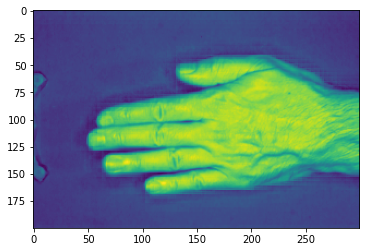

In [6]:
dataset[0][0][2]
plt.imshow(dataset[0][0][0])
plt.show()

In [7]:
# https://discuss.pytorch.org/t/how-to-use-imagefolder-with-list-of-images-for-train-and-test-sets/120247
# trainset = torch.utils.data.Subset(dataset_train, train_indices)
# valset = torch.utils.data.Subset(dataset_val, val_indices)
def get_data(): 
  n_val = int(np.floor(valid_size * len(dataset)))
  n_test = int(np.floor(test_size * len(dataset)))
  n_train = len(dataset) - n_val - n_test

  train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

  valid_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=True)
  test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=True)
  return train_dl, test_dl, valid_dl

In [8]:
@torch.no_grad()
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
@torch.no_grad()
def loss(x, y, model):
    prediction = model(x)
    loss = loss_fn(prediction, y)
    return loss.item()

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) # halbiert um 2
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # halbiert um 2
        self.fc1 = nn.Linear(8 * int((image_width/2)/2) * int((image_height/2)/2), 32)     # 18*12 bei 75/50 -> image_width = (75/2)/2  image_height = (50/2)/2 GEÄNDERT
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * int((image_width/2)/2) * int((image_height/2)/2)) # <1> GEÄNDERT
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [11]:
def get_model():
    model = Net().to(device)
    loss_fn = nn.CrossEntropyLoss()  # Kreuzentropie
    optimizer = SGD(model.parameters(), lr=1e-1)
    return model, loss_fn, optimizer

In [12]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [13]:
def is_early_stopping(val_accuracies, amount_epoch, threshold=0.01):

  # Wenn man mindestens <amount_epoch> vergleichen möchte aber noch nicht 
  # so viele epochen durchlaufen hat, kann noch kein Early Stopping stattfinden
  if len(val_accuracies) < amount_epoch: 
    return False

  # nur die letzten <amount_epoch> Elemente übernehmen
  epochs = val_accuracies[-amount_epoch:]
    

  # Betragliche differenz zwischen den Werten für index i und i+1 bilden
  abs_differences  = []
  for i in range(0 , len(epochs) -1):
    abs_differences.append(abs(epochs[i] - epochs[i + 1]))

  # Wenn alle Differenzen in der Liste kleiner sind als der Schwellwert ist Early Stopping!
  return all(x < threshold for x in abs_differences)


In [14]:
# Test Early stopping

assert is_early_stopping([0.1, 0.2, 0.3], 4, 0.1) == False, "Sollte False sein, da 0.1 < 0.1 false ist"
assert is_early_stopping([0.1, 0.1, 0.2, 0.3], 4, 0.11) == True, "Sollte True sein, da 0.1 < 0.11 True ist"
assert is_early_stopping([0.1, 0.2, 0.3, 0.5, 0.7, 0.9], 4, 0.11) == False, "Sollte False sein, da die letzten drei Größere differenzen haben als 0.11"

In [15]:
model, loss_fn, optimizer = get_model()

In [16]:
# 3 - R, G, B 
# 224 - Width 
# 224 - Height
summary(Net(), (3, image_width, image_height))
# Output Shape
# [-1, 16, 224, 224] 
# First Index: Batch-Size (-1 means it doesn't matter)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 300, 200]             448
              Tanh-2         [-1, 16, 300, 200]               0
         MaxPool2d-3         [-1, 16, 150, 100]               0
            Conv2d-4          [-1, 8, 150, 100]           1,160
              Tanh-5          [-1, 8, 150, 100]               0
         MaxPool2d-6            [-1, 8, 75, 50]               0
            Linear-7                   [-1, 32]         960,032
              Tanh-8                   [-1, 32]               0
            Linear-9                    [-1, 3]              99
Total params: 961,739
Trainable params: 961,739
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.69
Forward/backward pass size (MB): 18.54
Params size (MB): 3.67
Estimated Total Size (MB): 22.90
-----------------------------------------

In [17]:
train_dl, test_dl, val_dl = get_data()

In [19]:
print('Starting training...')

#time0 = timer()    << Zeile hat kein nutzen (dump)



arrPlotX = []
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epoch_time = []   # Kein nutzen zur Zeit (dump)

if TrainingMode:
    for pixel_step_reduce in range(6, 15, 3):  # GEÄNDERT

      image_width = int(pixel_step_reduce)             # GEÄNDERT
      image_height = int(pixel_step_reduce*(2/3))      # GEÄNDERT

      print(f"img_w: {image_width}  img_h: {image_height}") # GEÄNDERT

      transform = transforms.Compose([transforms.Resize((image_height, image_width)), transforms.ToTensor()]) # GEÄNDERT
      dataset = datasets.ImageFolder(path, transform=transform) # GEÄNDERT

      model, loss_fn, optimizer = get_model()     # GEÄNDERT
      train_dl, test_dl, val_dl = get_data()      # GEÄNDERT

      for epoch in range(epochs):
          time1 = timer()
          train_epoch_losses, train_epoch_accuracies = [], []

          for ix, batch in enumerate(iter(train_dl)):
              x, y = batch
            
              batch_loss = train_batch(x, y, model, optimizer, loss_fn)  # Mini-Batch
              train_epoch_losses.append(batch_loss)
          train_epoch_loss = np.array(train_epoch_losses).mean()

          for ix, batch in enumerate(iter(train_dl)):
              x, y = batch
              is_correct = accuracy(x, y, model)
              train_epoch_accuracies.extend(is_correct)
          train_epoch_accuracy = np.mean(train_epoch_accuracies)

          val_is_correct = None
          validation_loss = None

          for ix, batch in enumerate(iter(val_dl)):
              x, y = batch
              val_is_correct = accuracy(x, y, model)
              validation_loss = loss(x, y, model)

          val_epoch_accuracy = np.mean(val_is_correct)
          arrPlotX.append(epoch)
          train_losses.append(train_epoch_loss)
          train_accuracies.append(train_epoch_accuracy)
          val_losses.append(validation_loss)
          val_accuracies.append(val_epoch_accuracy)
       
          time2 = timer() - time1
          epoch_time.append(time2)    # Kein nutzen zur Zeit (dump)
        
          print(f"epoch: {epoch+1}  train_acc: {100 * train_epoch_accuracy:.2f}%  val_acc: {100 * val_epoch_accuracy:.2f}%  time: {time2} s")
          # Early stopping
          if is_early_stopping(val_accuracies, 5, 0.01):
              print(f'Early Stopping...')
              break

        

 #   torch.save(model.state_dict(), ModelPath)

    plt.plot(arrPlotX, train_accuracies)
    plt.plot(arrPlotX, val_accuracies)
    plt.savefig("accuracies.png")
else:
    val_is_correct = None
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = loss(x, y, model)

    for ix, var in enumerate(iter(val_is_correct)):
        if var is False:
            print(test_dl.dataset.__getitem__(ix))
    val_epoch_accuracy = np.mean(val_is_correct)
    print(f"test_acc: {100 * val_epoch_accuracy:.2f}%")


Starting training...
img_w: 6  img_h: 4
epoch: 0  train_acc: 34.02%  val_acc: 33.33%  time: 10.514669840000352 s
epoch: 1  train_acc: 38.01%  val_acc: 33.33%  time: 9.888356028999624 s
epoch: 2  train_acc: 34.02%  val_acc: 28.57%  time: 9.668976584998745 s
epoch: 3  train_acc: 42.81%  val_acc: 23.81%  time: 9.684915924000961 s
epoch: 4  train_acc: 32.42%  val_acc: 42.86%  time: 9.661102722999203 s
epoch: 5  train_acc: 34.02%  val_acc: 38.10%  time: 9.615268528999877 s
epoch: 6  train_acc: 34.02%  val_acc: 28.57%  time: 9.121816057000615 s
epoch: 7  train_acc: 33.79%  val_acc: 42.86%  time: 9.203398356999969 s
epoch: 8  train_acc: 55.59%  val_acc: 47.62%  time: 9.255983589000607 s
epoch: 9  train_acc: 34.25%  val_acc: 33.33%  time: 9.195668594999006 s
epoch: 10  train_acc: 61.07%  val_acc: 57.14%  time: 8.949283587999162 s
epoch: 11  train_acc: 40.30%  val_acc: 47.62%  time: 8.964279914000144 s
epoch: 12  train_acc: 57.19%  val_acc: 61.90%  time: 9.0251489759994 s
epoch: 13  train_acc: 

KeyboardInterrupt: ignored

In [ ]:
val_is_correct = None
for ix, batch in enumerate(iter(test_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = loss(x, y, model)

for ix, var in enumerate(iter(val_is_correct)):
    if var is False:
        print(test_dl.dataset.__getitem__(ix))
val_epoch_accuracy = np.mean(val_is_correct)
print(f"test_acc: {100 * val_epoch_accuracy:.2f}%")